<a href="https://colab.research.google.com/github/sifanurfa/Loan-Approval-Prediction/blob/main/Loan_Approval_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## read dataset

In [1]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/sifanurfa/dataset/refs/heads/main/loan_data.csv', delimiter=',')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            381 non-null    object 
 1   Gender             376 non-null    object 
 2   Married            381 non-null    object 
 3   Dependents         373 non-null    object 
 4   Education          381 non-null    object 
 5   Self_Employed      360 non-null    object 
 6   ApplicantIncome    381 non-null    int64  
 7   CoapplicantIncome  381 non-null    float64
 8   LoanAmount         381 non-null    float64
 9   Loan_Amount_Term   370 non-null    float64
 10  Credit_History     351 non-null    float64
 11  Property_Area      381 non-null    object 
 12  Loan_Status        381 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 38.8+ KB


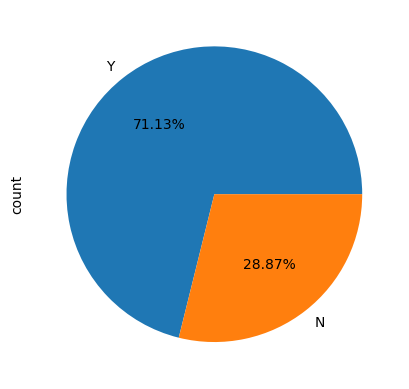

In [3]:
import matplotlib.pyplot as plt

data = df['Loan_Status'].value_counts()
data.plot(kind='pie', autopct='%.2f%%')
plt.show()

In [4]:
# ketagorical
cats = df.select_dtypes(include=['object', 'bool']).columns
print(cats)

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area', 'Loan_Status'],
      dtype='object')


## preprocessing

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.metrics import sensitivity_specificity_support
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Target dan fitur
X = df.drop(columns=['Loan_ID', 'Loan_Status'])
y = df['Loan_Status'].map({'N': 0, 'Y': 1})  # ubah Y/N ke 1/0


# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Definisikan kolom numerik dan kategorikal
numeric_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']


# Pipeline preprocessing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

## modelling

In [6]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay
)

def evaluate_and_save_best(models, preprocessor, X_train, y_train, X_test, y_test):
    results = []

    for name, model in models.items():
        # Pipeline: preprocessor + model
        pipe = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        results.append({
            'Model': name,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1-score': f1,
            'Pipeline': pipe
        })

        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f"Confusion Matrix - {name}")
        plt.show()

        print(f"Accuracy : {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall   : {rec:.4f}")
        print(f"F1-score : {f1:.4f}")

    results_df = pd.DataFrame(results).sort_values(by='F1-score', ascending=False)
    display(results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score']])

    # Ambil model terbaik
    best_model_row = results_df.iloc[0]
    best_name = best_model_row['Model']
    best_pipe = best_model_row['Pipeline']

    # Simpan pipeline lengkap (preprocessor + model)
    joblib.dump(best_pipe, f"{best_name}_best_pipeline.joblib")
    print(f"\n Model terbaik ({best_name}) disimpan sebagai '{best_name}_best_pipeline.joblib'")

    return results_df, best_pipe

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

models = {
    "Decision Tree": DecisionTreeClassifier(criterion="entropy", random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=10),
    "AdaBoost": AdaBoostClassifier(random_state=42)
}

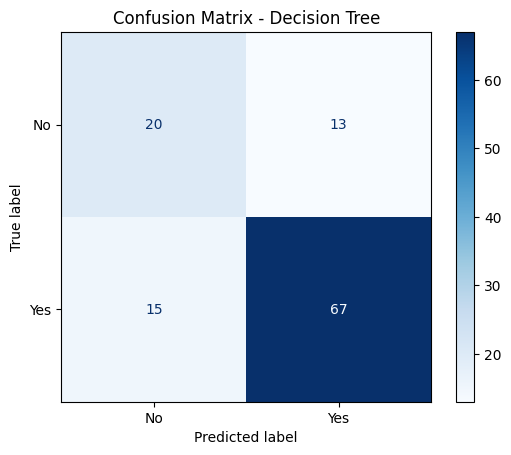

Accuracy : 0.7565
Precision: 0.8375
Recall   : 0.8171
F1-score : 0.8272


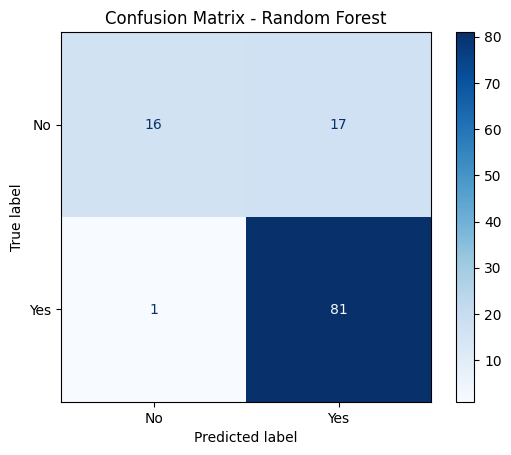

Accuracy : 0.8435
Precision: 0.8265
Recall   : 0.9878
F1-score : 0.9000


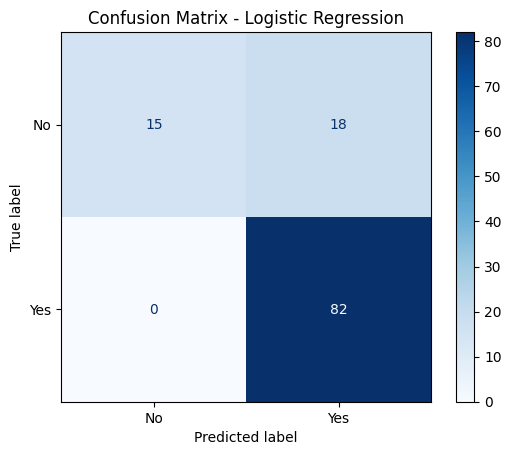

Accuracy : 0.8435
Precision: 0.8200
Recall   : 1.0000
F1-score : 0.9011


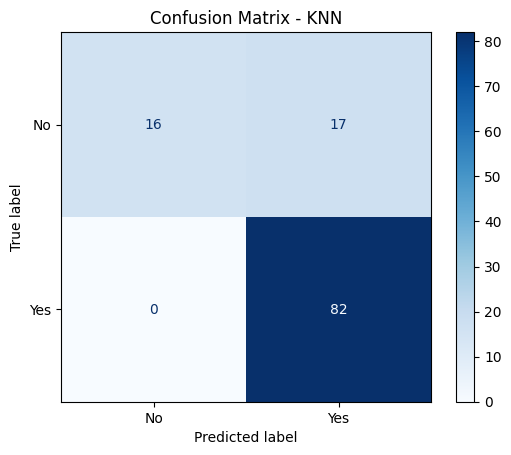

Accuracy : 0.8522
Precision: 0.8283
Recall   : 1.0000
F1-score : 0.9061


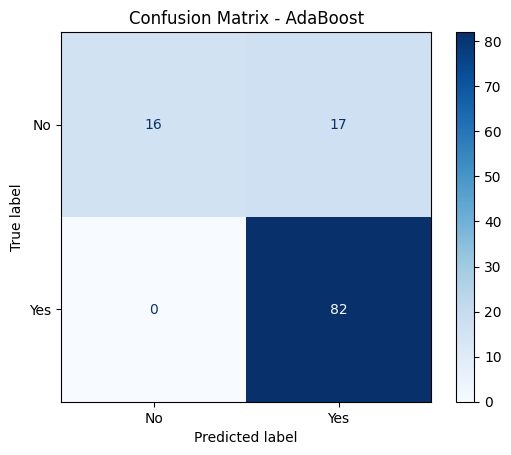

Accuracy : 0.8522
Precision: 0.8283
Recall   : 1.0000
F1-score : 0.9061


,Model,Accuracy,Precision,Recall,F1-score
4,AdaBoost,0.852174,0.828283,1.000000,0.906077
3,KNN,0.852174,0.828283,1.000000,0.906077
2,Logistic Regression,0.843478,0.820000,1.000000,0.901099
1,Random Forest,0.843478,0.826531,0.987805,0.900000
0,Decision Tree,0.756522,0.837500,0.817073,0.827160



 Model terbaik (AdaBoost) disimpan sebagai 'AdaBoost_best_pipeline.joblib'


In [8]:
results_df, best_pipeline = evaluate_and_save_best(models, preprocessor, X_train, y_train, X_test, y_test)

In [9]:
# from google.colab import files
# files.download('AdaBoost_best_pipeline.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>